## README

I followed the attached link to learn how pytorch neural nets work and and how to create a playing card classifier.

https://www.youtube.com/watch?v=tHL5STNJKag

In [ ]:
!pip3 install torch torchvision timm matplotlib pandas numpy tqdm ipywidgets

In [1]:
import torch
import torch.nn as nn # provides neural network functions like convolution layers
import torch.optim as optim # provides optimizer
from torch.utils.data import Dataset, DataLoader
import torchvision # helps working with images easier
import torchvision.transforms as transforms 
from torchvision.datasets import ImageFolder
import timm # pytorch image model library, pretrained weights optimized for image classification

import matplotlib.pyplot as plt # data visualization
import pandas as pd
import numpy as np
import sys
from tqdm import tqdm # for progress bar
import os
from PIL import Image
import random

## STEP 1: Set up data set and date loader

In [2]:
# Generate synthethic images

def log2img(class_name):
    pixel_data = []
    found_start = False
    log_path = f"../log_data/{class_name}.log"
    with open(log_path, 'r', encoding='utf-8', errors='ignore') as file:
        for line in file:
            # skip straight to the data
            if not found_start:
                if "index: 0" in line:
                    found_start = True
                continue
            else:
                parts = line.split(',')
                for part in parts:
                    if 'data:' in part:
                        # Extract the hex after 'data:'
                        word = part.split(': ')[1].strip().zfill(8)
                        # word = [R1, G1, B1, R0, G0, B0]
                        # print(f"word: {word}")
                        int_val = int(word, 16)  # Convert hexadecimal string to integer

                        # Extract individual R, G, and B components
                        R0 = ((int_val >> 27) & 0b11111) << 3
                        G0 = ((int_val >> 21) & 0b111111) << 2
                        B0 = ((int_val >> 16) & 0b11111) << 3
                        R1 = ((int_val >> 11) & 0b11111) << 3
                        G1 = ((int_val >> 5) & 0b111111) << 2
                        B1 = (int_val & 0b11111) << 3

                        p0 = [R0, G0, B0]
                        p1 = [R1, G1, B1]
                        
                        pixel_data.append(p1)
                        pixel_data.append(p0)

        height = 148
        width = 172
        data = np.array(pixel_data)
        target_shape = (height, width, 3)

        image_data = np.zeros((height * width, 3), dtype=np.uint8)
        image_data[:len(data)] = data
        image_data = image_data.reshape(target_shape)
        image = Image.fromarray(image_data)
        return image

def random_rotate_180(img):
    return img.rotate(180) if random.random() < 0.5 else img

# transform applied to all images
transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.02),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.Lambda(random_rotate_180), # handle card orientation
    transforms.RandomRotation(degrees=(-5,5)), # to handle camera rotation
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor()
])

# creates all the datasets for a specific class_name
def create_class_dataset(class_name):
    image = log2img(class_name)
    dataset_size = 10 # number of images per folder
    dataset_folders = ["train", "valid", "test"]

    for folder in dataset_folders:
        # make dir if doenst eist
        image_dir = f"../dataset/{folder}/{class_name}"
        os.makedirs(image_dir, exist_ok=True)
        if folder == "train":
            # save og image into training set
            image.save(os.path.join(image_dir, f"{class_name}-0.jpg"))

        # create and save syntehtic images
        for i in range(1, dataset_size):
            synthetic_image = transform(image)
            synthetic_image_pil = transforms.ToPILImage()(synthetic_image)
            synthetic_image_pil.save(os.path.join(image_dir, f"{class_name}-{i}.jpg"))

    

In [3]:
# Create all data sets by iterating througho the log_data
for log in os.listdir("../log_data"):
    class_name = os.path.splitext(log)[0]
    create_class_dataset(class_name)

In [4]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform) # Creates classes using folder name
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

# transform input images
transform = transforms.Compose([
    transforms.Resize((128, 128)), # resize input image to desired pixel dimensions
    transforms.ToTensor(), # converts pixel RGB val from [0,255] -> [0,1]
])

train_dir = "../dataset/train"
valid_dir = "../dataset/valid"
test_dir = "../dataset/test"

train_dataset = PlayingCardDataset(train_dir, transform)
valid_dataset = PlayingCardDataset(valid_dir, transform)
test_dataset = PlayingCardDataset(test_dir, transform)

# Data loading
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [5]:
## STEP 2: Design Neural Network

In [6]:
class CardClassifer(nn.Module):
    def __init__(self, num_classes=54):
        super(CardClassifer, self).__init__()

        # note: could design image classification architecture ourself by defining each layer
        # however, using an optimized image classificatino model with pretrained weights using timm
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)  

        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280 # default size of the efficientnet_b0, we will resize enout into our num of classe later

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )
    
    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output


## STEP 2: Train + Validate

In [8]:
# Note: want to validate the model on data it hasn't been trained on => split data into train and valid dataset.
# Terms: Epoch = one run through entire training dataset, step = one batch of data

# general idea: Load data in model in batches, then calculate loss and perform backpropagation to modify weights starting from last layer to minimize that loss

# training parameters
num_epochs = 5
train_losses, val_losses = [], []
model = CardClassifer()
criterion = nn.CrossEntropyLoss() # loss function (what model optimizes to minimize loss)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
train = True
if train:
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc='Training loop'):
            optimizer.zero_grad()
            outputs = model(images) # call forward on the images
            loss = criterion(outputs, labels)
            loss.backward() # backpropagation to update model weight
            optimizer.step()
            running_loss += loss.item() * labels.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc='Validation loop'):
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * labels.size(0)
        val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")
else: # load in already trained model
    # model = timm.create_model('efficientnet_b0', pretrained=False)  # define architetcture of model
    model_weights_path = "model.pth"
    model.load_state_dict(torch.load(model_weights_path))
    model.eval() # set to eval mode

Training loop:   0%|          | 0/17 [00:00<?, ?it/s]

Validation loop: 100%|██████████| 16/16 [00:33<00:00,  2.11s/it]


Epoch 1/5 - Train loss: 2.9846762639504893, Validation loss: 1.8566822936996021


Validation loop: 100%|██████████| 16/16 [00:33<00:00,  2.08s/it]


Epoch 2/5 - Train loss: 0.7114882846673329, Validation loss: 0.2733711516292988


Validation loop: 100%|██████████| 16/16 [00:32<00:00,  2.04s/it]


Epoch 3/5 - Train loss: 0.15318366592680965, Validation loss: 0.09525456257287121


Validation loop: 100%|██████████| 16/16 [00:33<00:00,  2.07s/it]


Epoch 4/5 - Train loss: 0.1017897919372276, Validation loss: 0.1779847816399341


Validation loop: 100%|██████████| 16/16 [00:33<00:00,  2.07s/it]

Epoch 5/5 - Train loss: 0.11198384783886096, Validation loss: 0.2862385844537766


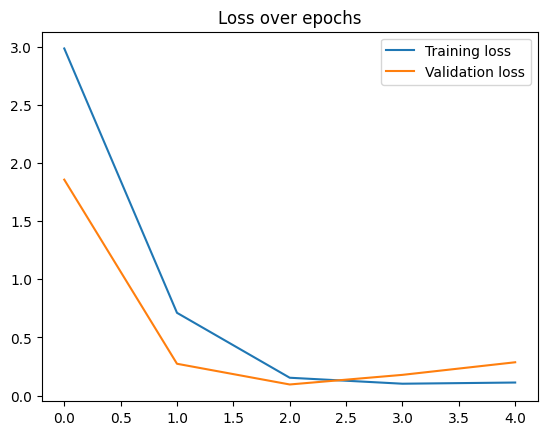

In [10]:
# Visualize Loss

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

## Assessing the model

In [12]:
from PIL import Image

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    # image = image.rotate(90)
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        probabilities = probabilities.cpu().numpy().flatten()
        print(train_dataset.classes[np.argmax(probabilities)])
    return probabilities

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

S3


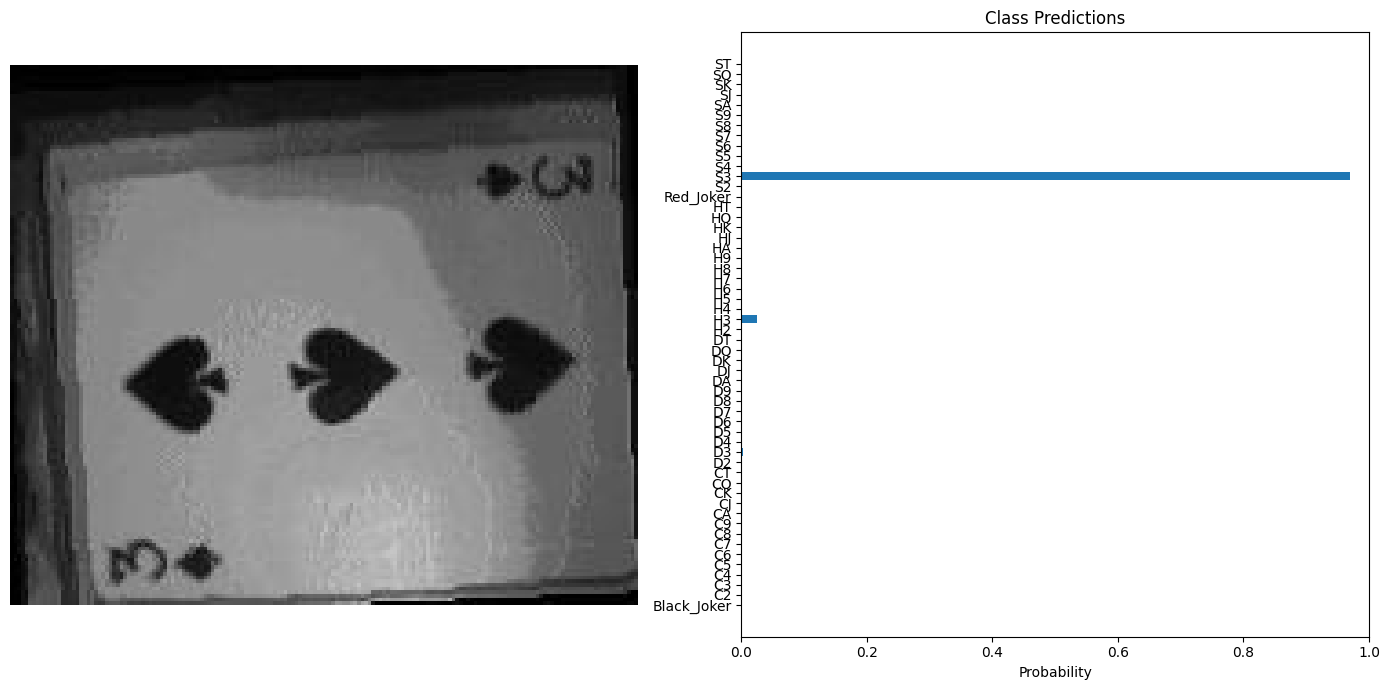

CK


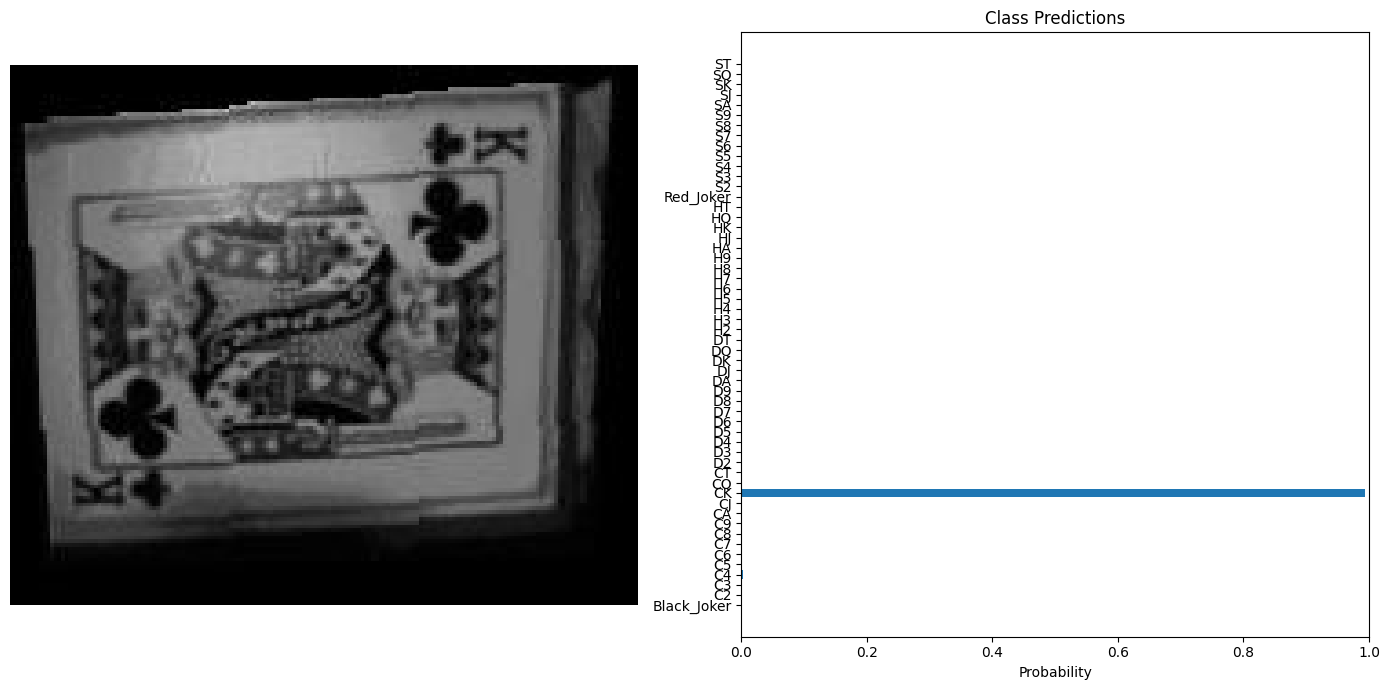

S3


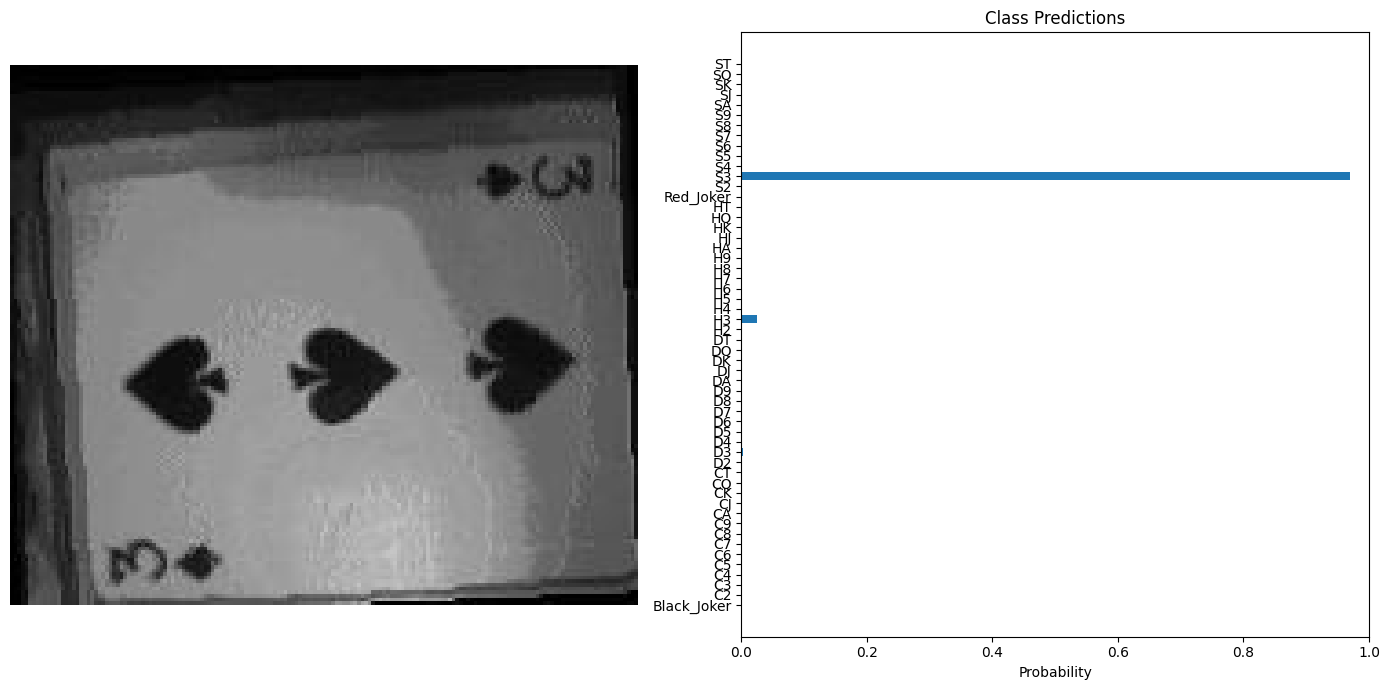

D5


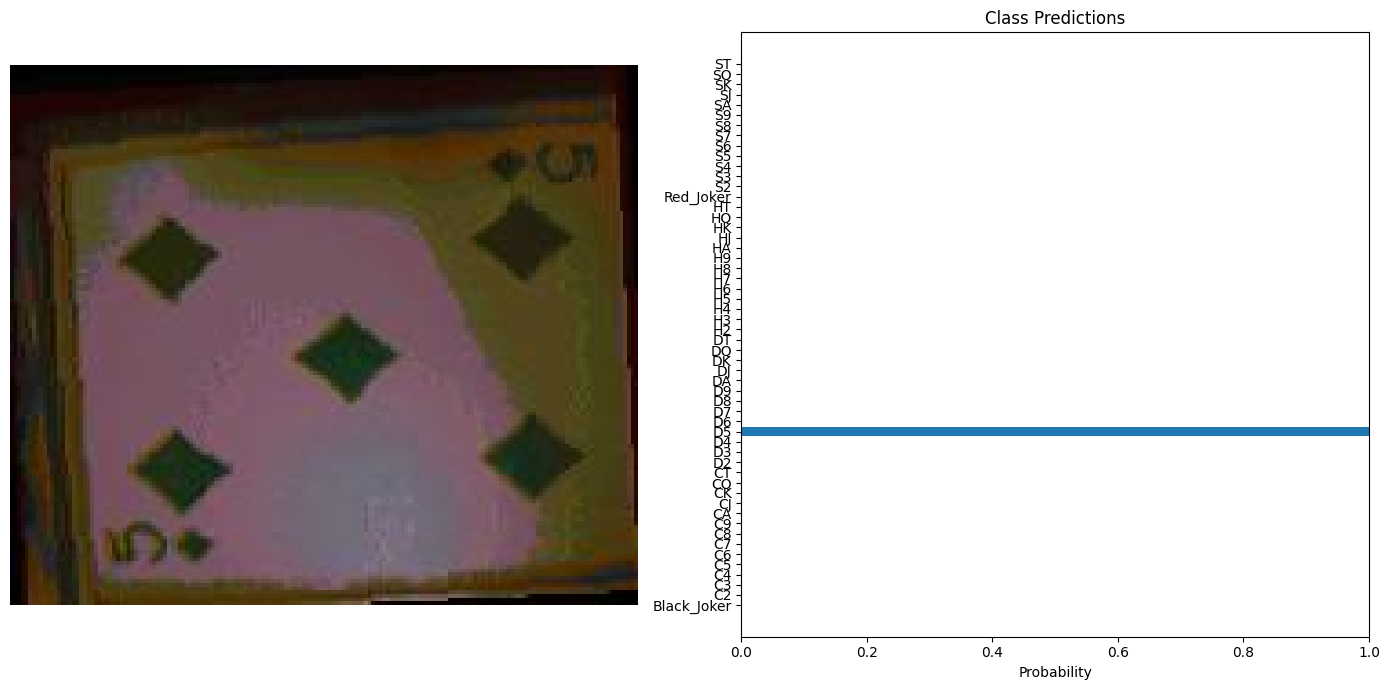

DJ


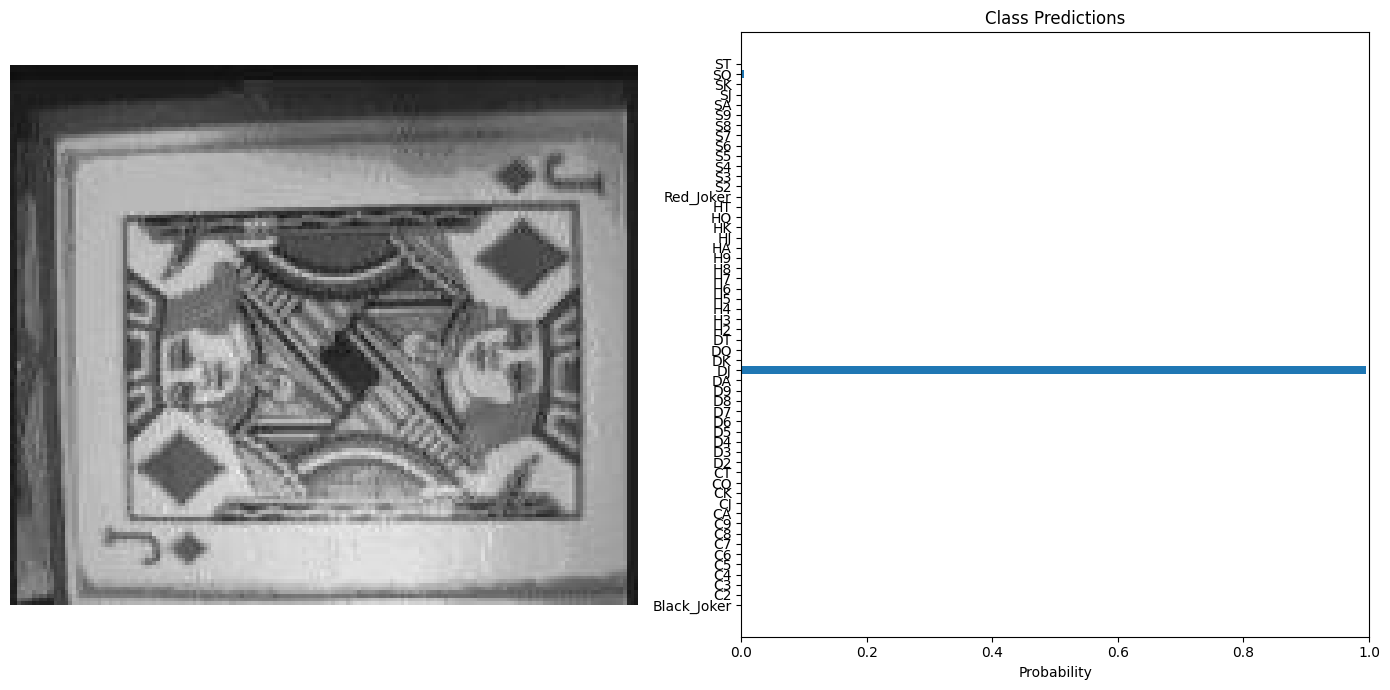

In [13]:
from glob import glob
test_images = glob("../dataset/test/*/*")
test_examples = np.random.choice(test_images, 5)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor)

    # Assuming dataset.classes gives the class names
    class_names = train_dataset.classes 
    visualize_predictions(original_image, probabilities, class_names)

## Step 3: Save the state_dict of the model as a pth

In [14]:
# save .pth (trained weighted sums)
model_path = "model.pth"
torch.save(model.state_dict(), model_path)